### Grenoble INP - École Nationale Supérieur de l’Énergie, l’Eau et l’Environnement
![GrenobleINP Logo](https://upload.wikimedia.org/wikipedia/fr/c/c6/Grenoble_INP_-_Ense3_%28logo%29.svg)
# Smart Energy Building Simulation Report
##### SMART CITIES (4EUS4HAT)
#### Professor: Christian GHIAUS & Majid BASEER

2A - SEM & M1-SGB Authors:
* Constanza MUÑOZ FILIPPIG
* Francisco J. CUESTA ELIAS
* Luca DORI
* Albert GRANOLLERS COLOM


##### TABLE OF CONTENTS

1. [INTRODUCTION](#INTRODUCTION)
2. [BUILDING PLAN](#BUILDING-PLAN)
3. [HYPOTHESES](#HYPOTHESES)
4. [THERMAL MODEL](#THERMAL-MODEL)
5. [MATHEMATICAL MODEL](#MATHEMATICAL-MODEL)
6. [MODEL IMPLEMENTATION](#MODEL-IMPLEMENTATION)
7. [STEADY-STATE RESULTS](#STEADY-STATE-RESULTS)
8. [DYNAMIC SIMULATION](#DYNAMIC-SIMULATION)
9. [OPTIMIZATION](#OPTIMIZATION)
10. [CONCLUSION](#CONCLUSION)

##### INTRODUCTION
Buildings account for almost 40% of total energy consumption, hence their contribution to greenhouse gasses emission is not negligible. For these reasons an appropriate way of modeling and control strategies should be applied in order to develop more efficient buildings that allow to reduce both consumption and emissions.

The simulation that is carried out in this project is devoted to define a virtual model of a house, accounting as much details as possible, in order to create an accurate approximation of real life behavior. Energy and mass flows between different spaces are considered to correctly assess the energy consumptions required to heat up and cool down the house.

The required inputs for this simulation are:
* Weather conditions of the site in analysis (Grenoble 38000, France)
* Building geometry
* Building envelope characteristics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

In [2]:
# P-controler gain
Kp = 0           # no controller Kp -> 0

##### BUILDING PLAN
The place considered for analysis is a flat of almost 25m2 facing south located at the third floor of a residence in Grenoble. The studio has 4 general walls, a separated bathroom, a main door and a window with the previous orientation mentioned. The materials of each wall is concrete covered with an insulation layer, the bathroom door is made of wood and the main door is made of iron whilst the window is double layered. Inside there’s electrical equipment that apport heat such as the computer, microwave, induction stove, fridge, and heater. The place will be occupied by one person who does home-office; hence, the importance of the analysis since each day a strong heat production will be generated inside the room. The studio will require a set point for temperature control and regulation; therefore, the objective is to determine the characteristics of this equipment to work at the optimal level.
![Drawingstudio](studio_drawing.PNG)


The dimension and surface areas for our problem are defined as follows:

In [3]:
l = 3               # m hight of the room
Sg = 0.9*l           # m² surface of the glass wall
Swo = 0.8*l             # m² surface of wood door

Va = l*((5.25-2)*(2.6))      # m³ volume of air
ACH = 2                      # air changes per hour
Va_dot = ACH * Va / 3600    # m³/s air infiltration

air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/kg.K

The thermophysical properties of the materials and surface areas of the materials of the walls on the designed room:

In [4]:
wall = {'Conductivity': [1.4,1.4,1.4,1.4, 0.027,0.027,0.027, 1.4, 1.7,1.7, 0.8],  # W/m.K
        'Density': [2300,2300,2300,2300, 55,55,55, 2500, 2500,2500, 250],        # kg/m³
        'Specific heat': [880,880,880,880, 1210,1210,1210, 750, 0,0, 1760],  # J/kg.K
        'Width': [0.15-0.0005,0.15-0.0005,0.15,0.15,
                  0.05,0.05,0.05,
                  0.004,
                  0.0005,0.0005,
                  0.08],
        'Surface': [2.6*l, 2*l, 4.66*l, (5.25-2-0.8)*l,
                    2*l, 4.66*l, (5.25-2-0.8)*l,
                    Sg,
                    2.6*l, 2*l,
                    Swo],  # m²
        'Slices': [1,1,1,1, 1,1,1, 1, 1,1, 1]}            # number of discretizations
wall = pd.DataFrame(wall, index=['Concrete_B1','Concrete_B3','Concrete_B5','Concrete_B6',
                                 'Insulation_B3','Insulation_B5','Insulation_B6',
                                 'Glass',
                                 'Ceramic_B1','Ceramic_B3',
                                 'Wood'])
wall

,Conductivity,Density,Specific heat,Width,Surface,Slices
Concrete_B1,1.400,2300,880,0.1495,7.80,1
Concrete_B3,1.400,2300,880,0.1495,6.00,1
Concrete_B5,1.400,2300,880,0.1500,13.98,1
Concrete_B6,1.400,2300,880,0.1500,7.35,1
Insulation_B3,0.027,55,1210,0.0500,6.00,1
Insulation_B5,0.027,55,1210,0.0500,13.98,1
Insulation_B6,0.027,55,1210,0.0500,7.35,1
Glass,1.400,2500,750,0.0040,2.70,1
Ceramic_B1,1.700,2500,0,0.0005,7.80,1
Ceramic_B3,1.700,2500,0,0.0005,6.00,1


##### HYPOTHESES
The following considerations were taken into account for the design, model, and implementation:
* The effect of surrounding buildings is neglected when considering the solar radiation effect.
* The wall besides the bathroom door is not considered in the analysis
* The insulator section of the wall includes a hard wall finishing for construction purposes.
* The only set point is considered in the main room.
* The two walls in contact with other rooms of the building don't have an influence on the model (North and East walls) because the difference of temperature between the rooms is considered 0.

##### THERMAL MODEL
For the thermal analysis the following design is proposed.
![Thermalmodel](diagram.PNG)

This design accounts the walls in contact with the exterior (South and East), the window at the south wall, 
the wall between the bathroom and the main room, the wall between the bathroom and the exterior; and finally the wood door to access the bathroom.


The radiative characteristics and factors are taken as following:

In [5]:
α_wSW = 0.2     # absortivity white surface

σ = 5.67e-8     # W/m².K⁴ Stefan-Bolzmann constant

In [6]:
# convection coefficients, W/m² K
h = pd.DataFrame([{'in': 4., 'out': 10}])

Thermal conductances of our model are presented:

In [7]:
# Conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']

Gw_B1 = h * wall['Surface'][0]     # wall branch 1
Gw_B3 = h * wall['Surface'][1]     # wall branch 3
Gw_B5 = h * wall['Surface'][2]     # wall branch 5
Gw_B6 = h * wall['Surface'][3]     # wall branch 6
Gg = h * wall['Surface'][7]        # glass branch 7
Gwood = h * wall['Surface'][10]    # wood branch 2

# ventilation & advection
Gv = Va_dot * air['Density'] * air['Specific heat']

# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

Thermal capacities of our model are presented:

In [8]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']
C['Air'] = air['Density'] * air['Specific heat'] * Va

##### MATHEMATICAL MODEL

The thermal circuit matrices generated for the model are presented: 

Matrix "A" is:

This matrix has x lines in accordance to the number of flows and columns are related to the number of temperature nodes.
The coefficients are either -1 or 1 depending on the direction of the flow, either exiting or entering respectively.


In [9]:
A = np.zeros([25, 19])

#Branch 1:

# flux 0
A[0, 0], A[0, 1] = -1,1
# flux 1 
A[1, 1], A[1, 2] = -1,1
#flux 2
A[2, 2], A[2, 3] = -1,1
#flux 3
A[3, 3], A[3, 4] = -1,1
#flux4
A[4, 4], A[4, 10] = -1,1


#Branch 2:

#flux 5
A[5, 0], A[5, 10] = -1,1

#Branch 3:

# flux 6 
A[6, 5], A[6, 0] = -1,1
# flux 7
A[7, 6], A[7, 5] = -1,1
#flux 8
A[8, 7], A[8, 6] = -1,1
#flux 9
A[9, 8], A[9, 7] = -1,1
#flux 10
A[10, 9], A[10, 8] = -1,1
#flux 11
A[11, 9] = 1

#Branch 4:

#flux 12
A[12, 10]  = 1


#Branch 5:

#flux 13
A[13, 10],A[13, 11]  = 1,-1
#flux 14
A[14, 12], A[14, 11] = -1,1
#flux 15
A[15, 13], A[15, 12] = -1,1
#flux 16
A[16, 14], A[16, 13] = -1,1
#flux 17
A[17, 14] =  1

#Branch 6:

#flux 18
A[18, 10],A[18, 15] = 1,-1
#flux 19
A[19, 16], A[19, 15] = -1,1
#flux 20
A[20, 17], A[20, 16] = -1,1
#flux 21
A[21, 18], A[21, 17] = -1,1
#flux 22
A[22, 18] = 1

#Branch 7:

#flux 23
A[23, 10] = 1

#Branch 8:

#flux 24
A[24, 10] = 1

Matrix "b" is:

This vector depicts the temperature sources. The number of rows depend on the number of known temperature sources. For this case 5 exterior temperature sources and the interior temperature we want to control in with the temperature source in flow branch 12.


In [10]:
b = np.zeros(25)
b[[11,17,22,23,24]] = 15
b[[12]] = 20

Matrix "C" is:

The matrix C represents the capacitance of the materials and their ability to store heat.
Its diagonal size is related to the capacitance located at specific nodes.

In [11]:
C_f = np.diag([0,#0                             // BRANCH 1
               0,#1
               C['Ceramic_B1'],#2
               C['Concrete_B1'],#3
               0,#4
               0,#5                            // BRANCH 2
               C['Ceramic_B3'],#6                 // BRANCH 3
               C['Insulation_B3'],#7
               C['Concrete_B3'],#8
               0,#9
               C['Air'],#10                    // BRANCH 4
               0,#11                           // BRANCH 5
               C['Insulation_B5'],#12
               C['Concrete_B5'],#13
               0,#14
               0,#15                          // BRANCH 6
               C['Insulation_B6'],#16
               C['Concrete_B6'],#17
               0])#18

Matrix "G" is:

This matrix shows the conductances depeding on the heat transfer method, either conduction or convection.
Its diagonal size is related to the number of flow branches. 

In [12]:
G = np.diag([Gw_B1.iloc[0]['in'],#0 Convection external // BRANCH 1
             2 * G_cd['Ceramic_B1'],#1 conduction ceramic
             1/(1/(2*G_cd['Ceramic_B1']) + 1/(2*G_cd['Concrete_B1'])),#2 conduction ceramic + conduction concrete
             2 * G_cd['Concrete_B1'],#3 conduction concrete
             Gw_B1.iloc[0]['in'],#4 conduction internal
             1/(1/Gwood.iloc[0]['in'] + 1/G_cd['Wood']+ 1/Gwood.iloc[0]['in']),#5 convection internal + conduction wood + convection internal  // BRANCH 2
             Gw_B3.iloc[0]['in'],#6 convention internal // BRANCH 3
             2 * G_cd['Ceramic_B3'],#7 conduction ceramic
             1/(1/(2*G_cd['Ceramic_B3']) + 1/(2*G_cd['Insulation_B3'])),#8 conduction ceramic + conduction insulation
             1/(1/(2*G_cd['Insulation_B3']) + 1/(2*G_cd['Concrete_B3'])),#9 conduction insulation + conduction concrete
             2 * G_cd['Concrete_B3'],#10
             Gw_B3.iloc[0]['out'],#11
             Kp,#12                                    // BRANCH 4
             Gw_B5.iloc[0]['in'],#13                      // BRANCH 5
             2 * G_cd['Insulation_B5'],#14
             1/(1/(2*G_cd['Insulation_B5']) + 1/(2*G_cd['Concrete_B5'])),#15 conduction insulation + conduction concrete
             2*G_cd['Concrete_B5'],#16
             Gw_B5.iloc[0]['out'],#17
             Gw_B6.iloc[0]['in'],#18                        // BRANCH 6
             2 * G_cd['Insulation_B6'],#19
             1/(1/(2*G_cd['Insulation_B6']) + 1/(2*G_cd['Concrete_B6'])),#20 conduction insulation + conduction concrete
             2*G_cd['Concrete_B6'],#21
             Gw_B6.iloc[0]['out'],#22
             1/(1/Gg.iloc[0]['in']+ 1/G_cd['Glass']+ 1/Gg.iloc[0]['out']),#23   // BRANCH 7
             Gv #24                                                             // BRANCH 8
            ])
np.set_printoptions(precision=3, threshold=16, suppress=True)

Matrix "f" is:

This vector demonstrates the nodes in which heat sources are present.

In [13]:
f = np.zeros(19)
f[[9, 14, 18]] = 0 #000 + np.array([4000, 1000, 2000,4000, 1000, 2000,4000, 1000])

Matrix "y" is:

This output vector has the size of the number of nodes in the model. For this case 19.


In [14]:
y = np.ones(19)

Matrix "u" is:

This input vector is a concatenation of the non-zero elements both vectors b and f.

In [15]:
u = np.hstack([b[np.nonzero(b)], f[np.nonzero(f)]])

##### MODEL IMPLEMENTATION

The complete analysis was carried by inserting the previous matrices into a state space representation.

In [16]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C_f, f, y)

Let's compare the steady state results obtained with the differential-algebraic equations of the thermal circuit:
$$y_{tc} = (A^T G A)^{-1}(A^T G b + f)$$
and the state-space:
$$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$ 

##### STEADY-STATE RESULTS

In [17]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)

print(np.array_str(yss, precision=3, suppress_small=True))
print(np.array_str(ytc, precision=3, suppress_small=True))
print(f'Max error in steady-state between thermal circuit and state-space:\
 {max(abs(yss - ytc)):.2e}')

[15. 15. 15. ... 15. 15. 15.]
[15. 15. 15. ... 15. 15. 15.]
Max error in steady-state between thermal circuit and state-space: 7.28e-12


The error is neglectable, so the steady state matrices were correctly constructed.

##### DYNAMIC SIMULATION

In [18]:
b = np.zeros(25)
b[[11,12,17,22,23,24]] = 1
f = np.zeros(19)
f[[9, 14, 18]] = 1

Let's consider that the output of the circuit is the indoor temperature at node 10:

In [19]:
y = np.zeros(19)
y[[10]] = 1

The state-space representation is obtained from the differential-algebraic equations of the thermal circuit:

In [20]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C_f, f, y)

##### Time Step

The maximum time step for numerical stability of Euler explicit itegration in time is given by the minimum eigenvalue $\lambda$ of the state matrix $A_s$:

$$ \Delta t \leq \min (-2 / \lambda_i) = \min T_i/2$$

where $T_i$ is the time constants, $T_i = - \frac{1}{\lambda_i} $

In [21]:
dtmax = min(-2. / np.linalg.eig(As)[0])
print(f'Maximum time step: {dtmax:.2f} s')

Maximum time step: 816.13 s


This time step should be smaller than dtmax:

In [22]:
dt = 400

##### Step Response

A dynamic response of the system to a step input will be obtained for the duration of the simulation:

In [23]:
duration = 3600 * 24 * 15      # [s]
n = int(np.floor(duration / dt))
t = np.arange(0, n * dt, dt)    # time
# Vectors of state and input (in time)
n_tC = As.shape[0]              # no of state variables (temps with capacity)
# u = [To To To To Tv Tsp Phi1 Phi2 Phi3]
u = np.zeros([9, n])
u[0:5, :] = np.ones([5, n])

The vectors for the evolution of temperatures (states) in time for Euler explicit and implicit are:

In [24]:
temp_exp = np.zeros([n_tC, t.shape[0]])
temp_imp = np.zeros([n_tC, t.shape[0]])

I = np.eye(n_tC)
for k in range(n - 1):
    temp_exp[:, k + 1] = (I + dt * As) @\
        temp_exp[:, k] + dt * Bs @ u[:, k]
    temp_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (temp_imp[:, k] + dt * Bs @ u[:, k])

The outputs to obtain are:

[Text(0.5, 0, 'Time [h]'),
 Text(0, 0.5, '$T_i$ [°C]'),
 Text(0.5, 1.0, 'Step input: To = 1°C')]

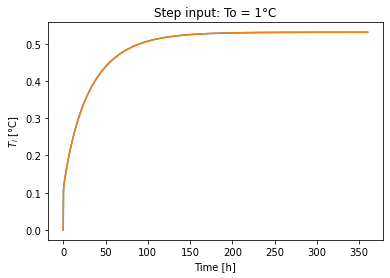

In [25]:
y_exp = Cs @ temp_exp + Ds @  u
y_imp = Cs @ temp_imp + Ds @  u

fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time [h]',
       ylabel='$T_i$ [°C]',
       title='Step input: To = 1°C')

In [26]:
b = np.zeros(25)
b[[11,17,22,23,24]] = 1
b[[12]] = 1
f = np.zeros(19)

ytc = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: {ytc[18]:.4f} °C')
print('- response to step input:', y_exp[0,len(y_exp[0])-1], '°C')

Steady-state indoor temperature obtained with:
- DAE model: 1.0000 °C
- response to step input: 0.5310659369503331 °C


##### SIMULATION WITH WEATHER DATA

Read the hourly weather data file from start date to end date. The data selected is for GRENOBLE and is 1 month of 2000.

In [27]:
# P-controler gain
Kp = 1e5            # almost perfect controller Kp -> ∞
dt = 5

In [28]:
filename = 'FRA_AR_Grenoble.074850_TMYx.epw'
start_date = '2000-01-03 12:00:00'
end_date = '2000-02-05 18:00:00'

# Read weather data from Energyplus .epw file
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather[(weather.index >= start_date) & (
    weather.index < end_date)]

From weather data, the hourly solar radiation on two tilted south and west surfaces, Φt1 and Φt2 [W] are calculated:

In [29]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.5
rad_surf1 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation, albedo)
rad_surf1['Φt1'] = rad_surf1.sum(axis=1)

surface_orientation2 = {'slope': 90,
                       'azimuth': 270,
                       'latitude': 45}
albedo = 0.5
rad_surf2 = dm4bem.sol_rad_tilt_surf(weather, surface_orientation2, albedo)
rad_surf2['Φt2'] = rad_surf2.sum(axis=1)


The weather data is at the time-step of 1h. It needs to be at time step of `dt`. 

In [30]:
data = pd.concat([weather['temp_air'], rad_surf1['Φt1'],rad_surf2['Φt2']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
data['Tv'] = 20 * np.ones(data.shape[0])

The indoor temperature setpoint Ti and auxiliary heat flow Qa constant for the whole simulation period are considered as follow:


In [31]:
data['Ti'] = 20 * np.ones(data.shape[0])


The simulation time vector, at time step `dt`is:

In [32]:
t = dt * np.arange(data.shape[0])

The input vector is formed by the temperature sources $\left [ T_o, T_o ,T_o, T_{i,sp} \right ]$ and the heat flow sources $\left [ \Phi_o, \Phi_i, \dot{Q_a}, \Phi_a \right ]$

In [33]:
# u = [To To To To Tsp Phio Phi1 .... Phi8]

u = pd.concat([data['To'],
               data['To'],
               data['To'],
               data['To'],
               data['Ti'],
               data['Tv'],
               α_wSW * wall['Surface']['Glass'] * data['Φt1'],
               α_wSW * wall['Surface']['Concrete_B6'] * data['Φt1'],
               α_wSW * wall['Surface']['Concrete_B5'] * data['Φt2']], axis=1)

The initial value of the state-vector can be different of zero:

In [34]:
temp_exp = 20 * np.ones([As.shape[0], u.shape[0]])

for k in range(u.shape[0] - 1):
    temp_exp[:, k + 1] = (I + dt * As) @ temp_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

yields the time variation of state variable $\theta$, from which we obtain the variation of the output (i.e. indoor temperature):
$$y = C_s \theta + D_s u$$
and the variation of the heat flow of the HVAC system:
$$q_{HVAC} = K_p (T_{i,sp} - y)$$
where $K_p$ is the gain of the P-controller and $T_{i,sp}$ is the HVAC-setpoint for the indoor temperature.

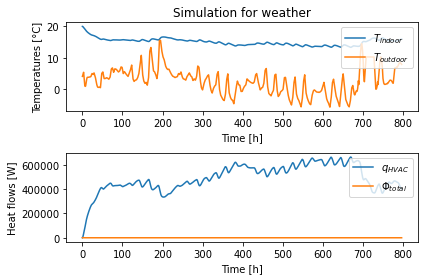

In [35]:
y_exp = Cs @ temp_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])

fig, axs = plt.subplots(2, 1)
# plot indoor and outdoor temperature
axs[0].plot(t / 3600, y_exp[0, :], label='$T_{indoor}$')
axs[0].plot(t / 3600, data['To'], label='$T_{outdoor}$')
axs[0].set(xlabel='Time [h]',
           ylabel='Temperatures [°C]',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600,  q_HVAC, label='$q_{HVAC}$')
axs[1].plot(t / 3600, data['Φt1'], label='$Φ_{total}$')
axs[1].set(xlabel='Time [h]',
           ylabel='Heat flows [W]')
axs[1].legend(loc='upper right')

fig.tight_layout()

##### CONCLUSION

The time step depends on:

- P-controller gain `Kp`:
    - if $K_p \rightarrow \infty$, then the controller is perfect and the time step needs to be small;
    - if $K_p \rightarrow 0$, then,the controller is inefffective and the building is in free-running.
- Capacities considered into the model:
    - if the capacities of the air $C_a =$ `C['Air']` and $C_g =$ `C['Glass']`are considered, then the time step is small;
    - if the capacities of the air and of the glas are zero, then the time step is large.

The controller models an HVAC system capable to heat (when $q_{HVAC} > 0$) and to cool $q_{HVAC} < 0$).

In this report, we have developed the code for an smart energy building simulation. In order to so, first of all it has been designed a room of nearly 25 m2, and we have defined the dimensions and the orientation. Afterwards, before implementing the thermal diagram, it has been defined that just one room of our model will be applied the temperature control, reminding that no control (Kp -->0 ) and perfect control (Kp -->  ∞). 
Once, the mathematical model has been defined (matrix A, G and C), the matrixes have been inserted in the state space representation. The error between the DAE and the state space model have been computed, and as expected, we got an error of nearly 0 which allos us to say that the steady state matrixes were well constructed. 
Regarding our results of the dynamic simulation, the step input was set to 1 degree (DAE), and Kp = 0, and our reponse to the step input it's been 0.53 °C. This result was mainly influenced by the conductances and capacitances of the model.
After having done that, we have moved towards the last part, which is the simulation taking into account the weather data (temperature of Grenoble during the year 2000). Now we have set controller ( Kp = 1e5) and two different walls orientations of the azmiuth angle have been defined, South and West. The goal is to achive a constant temperature of 20 °C inside the room (blue line as can be seen in the graph called "simulation of weather"). Nevertheless, looking closer the graph we can see that our controller is not working perfectly, and instead of reaching a constant temperature of 20 °C, the value is around 16 °C. 


